# Neural Network Final Model - Cape Matatula, American Samoa

In [1]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = config.site
site_name = config.site_dict[site]
assert site == 'SMO', 'This script is only for Cape Matatula, American Samoa. The site can be changed in the config file.'

compound = config.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Cape Matatula, American Samoa.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
2641,2000-12-04 17:00:00,1.0,-6.433093,-4.834558,-7.755699,-6.569259,-5.733766,-6.932024,-5.002582,-4.150133,...,-0.164754,0.356463,1.542770,5.077570,4.436603,3.318354,-4.409443,-8.740283,2.755785,-0.413732
14955,2005-10-16 13:00:00,1.0,-4.762187,-4.923864,-5.343726,-2.044029,-1.384388,-2.455931,-1.475922,-2.937976,...,-2.054787,1.072685,1.527481,0.653952,-3.609507,-7.663600,-2.459495,0.863319,-3.099615,-0.161474
17329,2006-09-03 11:00:00,1.0,-9.892614,-5.059865,-3.527909,-8.139325,-9.458179,-10.405249,-5.878890,-7.514195,...,1.912392,0.961714,-2.096064,-3.546405,-4.192015,0.663741,-1.276129,2.173880,1.339756,3.149895
55121,2021-07-16 21:00:00,1.0,-10.212129,-11.360185,-11.068811,-10.920875,-7.421020,-9.406633,-9.591132,-9.303134,...,-0.294579,5.220552,-5.495043,-6.319930,-2.448618,-4.830964,-2.748396,4.040298,6.176469,-1.856009
41224,2015-08-02 15:00:00,1.0,-8.239768,-2.852933,-3.977181,-5.386139,-4.015411,-6.459582,-6.990770,-10.213113,...,-4.618887,-6.506410,-1.762471,-0.953991,-2.339957,-4.222133,-8.428154,10.481296,-9.851550,-5.786691


In [4]:
train_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2014-01-01 05:00:00 -> 2018-12-31 23:00:00. Length: 11450
Val range: 2019-01-01 01:00:00 -> 2019-12-31 23:00:00. Length: 2126
Test range: 2020-01-01 01:00:00 -> 2022-12-31 23:00:00. Length: 7925


### Model

In [5]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.05, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

y_pred_val = nn_model.predict(X_val)
y_pred_train = nn_model.predict(X_train)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")

Precision on Training Set = 0.789
Precision on Validation Set = 0.754
Recall on Training Set = 0.947
Recall on Validation Set = 0.924
F1 Score on Training Set = 0.861
F1 Score on Validation Set = 0.831


In [6]:
# evaluating model on test set

y_pred_test = nn_model.predict(X_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.852
Recall on Testing Set = 0.949
F1 Score on Testing Set = 0.898


In [7]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model_SMO.joblib']

### Assessing Feature Importance

In [8]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

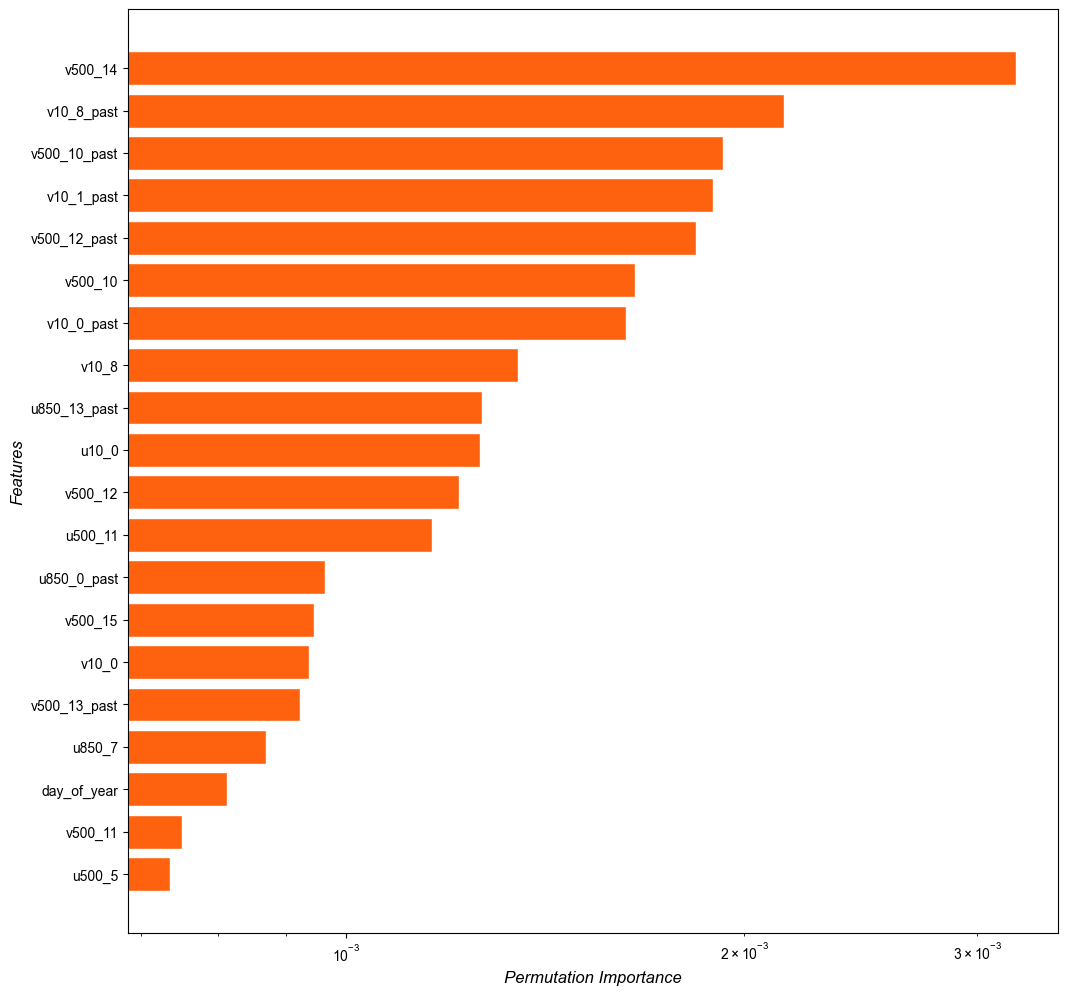

In [9]:
# plotting first 20 most important features in a histogram

fig, ax = plt.subplots(figsize=(12, 12))
sns.set_theme(style='ticks', font='Arial')

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:], color='#FF620E')

ax.set_xscale('log')

ax.set_ylabel('Features', fontsize=12, fontstyle='italic')
ax.set_xlabel('Permutation Importance', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importance (Testing Set)', fontsize=14)

In [15]:
# determining where blh lies in list of features
blh_index = X_val.columns.get_loc('blh')
print(f"Position of 'blh': {blh_index}")

Position of 'blh': 103
